# Document AI: Fine-tuning Donut for document-parsing using Hugging Face Transformers 

TODO: Add intro for blog why Donut and not LayoutLM and what is DocumentAI

In this blog, you will learn how to fine-tune [Donut-base](https://huggingface.co/naver-clova-ix/donut-base) for document-understaind/document-parsing using Hugging Face Transformers.We are going use all of the great features from the Hugging Face ecosystem like model versioning and experiment tracking.


As dataset we will use the [SROIE](https://github.com/zzzDavid/ICDAR-2019-SROIE) dataset a collection of 1000 scanned receipts including their OCR. More information for the dataset can be found at the [repository](https://github.com/zzzDavid/ICDAR-2019-SROIE).

You will learn how to:

1. [Setup Development Environment](#1-setup-habana-gaudi-instance)
2. [Load and process the dataset](#2-load-and-process-the-dataset)
3. [Create a `Trainer` and define Hyperparameters](#3-create-a-gauditrainer-and-an-run-single-hpu-fine-tuning)
4. [Run training and evaluation](#4-run-distributed-data-parallel-training-with-gauditrainer)

Before we can start make sure you have a [Hugging Face Account](https://huggingface.co/join) to save artifacts and experiments. 

## Quick intro: Document Understanding Transformer (Donut) by ClovaAI

Document Understanding Transformer (Donut) is a new Transformer model for OCR-free document understanding. It doesn't require an OCR engine to process scanned documents, but is achieving state-of-the-art performances on various visual document understanding tasks, such as visual document classification or information extraction (a.k.a. document parsing). 
Donut is a multimodal sequence-to-sequence model with a vision enconder ([Swin Transformer](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/swin#overview)) and text decoder ([BART](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/bart)). The encoder receives the images and computes it into a embedding, which is then passed to the decoder, which generates a sequence of tokens.

![donut](../assets//donut.png)

* Paper: https://arxiv.org/abs/2111.15664
* Official repo:  https://github.com/clovaai/donut

--- 

Now we know how Donut works, so lets get started. 🚀

## 1. Environment setup

Our first step is to install the Hugging Face Libraries including transformers and datasets. Running the following cell will install all the required packages.

_Note: As the time of writing this Donut is not yet included in the PyPi version of Transformers, so we need it to install from the `main` branch. Donut will be added in version `4.22.0`._


In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git 
# !pip install -q "transformers>=4.22.0" # comment in when version is released
!pip install -q datasets sentencepiece tensorboard

In [ ]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs


This example will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model versioning service. To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join). 
If you already have an account you can skip this step. 
After you have an account, we will use the `notebook_login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk. 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load and process the dataset

As dataset we will use the [SROIE](https://github.com/zzzDavid/ICDAR-2019-SROIE) dataset a collection of 1000 scanned receipts including their OCR, more specifically we will use the dataset from task 2 "Scanned Receipt OCR". The available dataset on Hugging Face ([darentang/sroie](https://huggingface.co/datasets/darentang/sroie)) is not compatible with Donut. Thats why we will use the original dataset together with the `imagefolder` feature of `datasets` to load our dataset. Learn more about loading image data [here](https://huggingface.co/docs/datasets/v2.4.0/en/image_load#load-image-data).

_Note: The test data for task2 is sadly not available. Meaning that we end up only with 624 images._

As first we will cone the repository and extract the dataset into a separate folder and remove the unnecessary files.


In [36]:
%%bash 
# clone repository
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data
cp -r ICDAR-2019-SROIE/data ./
# clean up
rm -rf ICDAR-2019-SROIE
rm -rf data/box

Cloning into 'ICDAR-2019-SROIE'...
Updating files: 100% (1980/1980), done.


Now we have two folders inside the `data/` directory. One is containing the images of the receipts and the other is containing the OCR text. The nex step is to create a `metadata.json` file that contains the information about the images including the OCR-text. This is necessary for the `imagefolder` feature of `datasets`.

The `metadata.json` should look at the end similar to the example below

```json
{"file_name": "0001.png", "text": "This is a golden retriever playing with a ball"}
{"file_name": "0002.png", "text": "A german shepherd"}
```

In our example will `"text"` column contain the OCR text of the image as json string, adjusted to match the Donut requirements. As we learned in the Introduction donut is a sequence-to-sequence model with a vision encoder and text decoder. When fine-tuning the model we want it to generate the `"text"` based on the image we pass it. The `"text"` is not a raw JSON string 

In [37]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():    
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file
      
# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
# shutil.rmtree(metadata_path)

Good Job! Now we can load the dataset using the `imagefolder` feature of `datasets`.

In [41]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Using custom data configuration default-622752eb70f89a07
Reusing dataset imagefolder (/home/ubuntu/.cache/huggingface/datasets/imagefolder/default-622752eb70f89a07/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


Dataset has 626 images
Dataset features are: dict_keys(['image', 'text'])


Now, lets take a closer look at our dataset

Random sample is 216
OCR text is {"company": "ADVANCO COMPANY", "date": "17/01/2018", "address": "NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR", "total": "7.00"}


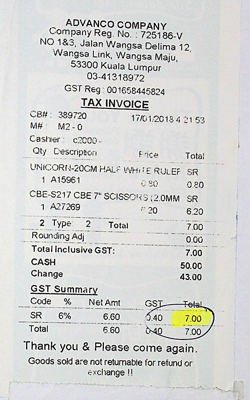

In [56]:
import random

random_sample= random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))
